# scBoolSeq supp. info. : Zero-inflation diagnostics

In [1]:
import pandas as pd
import plotnine as g
from plotnine import *
import matplotlib.pyplot as plt

from scboolseq import scBoolSeq
from scboolseq.simulation import sample_from_criteria
from scboolseq.utils.customobjs import Timer, Path as path
from scboolseq.utils.diagnostics import *

import warnings
warnings.filterwarnings('ignore') # prevent plotnine from showing warnings about missing values
                                    # we know that discarded genes will not be simulated

## Parameter declaration

In [2]:
UMQ = 0.25 # unimodal margin quantile
ALPHA = 1.0 # alpha multiplier for IQR
RNG_SEED = 1234 # seed for the random number generator
THREADS = 12 # number of threads to use for parallel processing
TEXT_SIZE = 16 # the article's figures used TEXT_SIZE = 16
SAVE_FIGURES = True # should the figures be saved ?

In [3]:
if SAVE_FIGURES:
    _publish_dir = path("zero_inf_figures")
    if not _publish_dir.exists():
        print("creating publish dir...", end="\t")
        _publish_dir.mkdir()
        print("done")
    else:
        print("publish directory to save figures already exists.")

publish directory to save figures already exists.


In [4]:
f_compute_dor = lambda x: (x == 0).sum()/len(x)


def resume_dor_criteria(df: pd.DataFrame):
    """ Compute gene-wise descriptive statistics 
    for a given expression DataFrame. 
    These include :
        * Mean
        * Median
        * Non-zero Mean (Mean_nz)
        * Non-zero Median (Median_nz)
        * Variance
        * DropOutRate
    """
    _mean = df.mean()
    _mean.name = "Mean"
    _median = df.median()
    _median.name = "Median"
    df_nz = df.replace(0.0, np.nan)
    _mean_nz = df_nz.mean(skipna=True)
    _mean_nz.name = "Mean_nz"
    _median_nz = df_nz.median(skipna=True)
    _median_nz.name = "Median_nz"
    _variance = df.var()
    _variance.name = "Variance"
    _dor = df.apply(f_compute_dor)
    _dor.name = "DropOutRate"
    
    _attrs = [_mean, _median, _mean_nz, _median_nz, _variance, _dor]
    return pd.concat(_attrs, axis="columns")

def violin_plot_preproc(
    unambiguous_df,
    column="Category",
    category_order=["Pooled", "Bimodal", "Unimodal", "ZeroInf", "Discarded"],
) -> pd.DataFrame:
    """This function prepares a comparison DataFrame to produce
    a violin plot for the supp. mat. of scBoolSeq main Article :
    * Concat unambiguous and category-pooled DataFrames
    * Change `column` to a categorical variable.
    * Sort the frame according to `column`.
    * Return the enhanced comparison DataFrame.
    """
    masked_df = unambiguous_df.copy(deep=True)
    # mask the column's values (Category)
    masked_df[column] = "Pooled"
    # concat the two DataFrames
    pooled_df = pd.concat([unambiguous_df, masked_df], axis="rows")
    # sort according to the specified order
    pooled_df[column] = pd.Categorical(pooled_df[column], categories=category_order)
    sorted_pooled_df = pooled_df.sort_values(column)

    return sorted_pooled_df


def save_plot_dict(
    plot_dict, location, tag="_my_plot", extension="png", width=40, height=25
):
    """save a dictionary of plotnine plots to a specified location
    note: width and height units are "cm". """
    for _name, _plot in plot_dict.items():
        _plot.save(
            location.joinpath(f"{_name}{tag}.{extension}"),
            height=height,
            width=width,
            units="cm",
            verbose=False,
        )
        
def plot_zero_inflation(frame, name, by):
    return (
        ggplot(frame)
            + geom_point(aes(x="Mean", y="DropOutRate", fill="Variance"))
            + g.ggtitle(f"Profile by {by} in dataset {name}")
    )

## Import datasets

The datasets here presented are not included in [scBoolSeq-supplementary](https://github.com/bnediction/scBoolSeq-supplementary)'s version history but they can be downloaded as part of the latest release.
Uncompress the `figures_datasets.tar.xz` archive in the repository's root to be able to continue this notebook's execution.

In [5]:
files = path("data_filtered_vargenes").resolve().lglob("*csv")
frames = {
    file.name.replace(file.suffix, ""): pd.read_csv(file, index_col=0) for file in files
}
frames.keys()

dict_keys(['GSE156234_Macrophages', 'GSE122466_Retina', 'GSE81682_Hematopoiesis'])

In [6]:
transposed_frames = { source: frame.T for source, frame in frames.items() }

In [7]:
transposed_frames['GSE122466_Retina'].head()

,Lane1_AAACCTGAGATGTCGG,Lane1_AAACCTGCAATCCAAC,Lane1_AAACCTGGTTCCTCCA,Lane1_AAACCTGTCCAATGGT,Lane1_AAACGGGAGGCAATTA,Lane1_AAACGGGCACCAGGCT,Lane1_AAACGGGCACGGCGTT,Lane1_AAACGGGCACTCAGGC,Lane1_AAACGGGCATCCAACA,Lane1_AAACGGGGTCCAAGTT,...,Lane2_TTTGGTTCATAAAGGT,Lane2_TTTGGTTGTGGCCCTA,Lane2_TTTGGTTTCTAACTCT,Lane2_TTTGTCAAGCGTGAAC,Lane2_TTTGTCAAGGGCTCTC,Lane2_TTTGTCAAGTACCGGA,Lane2_TTTGTCACATCGATGT,Lane2_TTTGTCAGTAGAGGAA,Lane2_TTTGTCAGTCATCCCT,Lane2_TTTGTCATCAGTTCGA
St18,0.0,0.000000,0.0,9.516215,0.000000,0.000000,0.00000,0.0,0.000000,0.0,...,0.0,0.0,9.654137,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
Mybl1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.0,10.230598,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,7.529213,0.0,0.000000
Tfap2d,0.0,0.000000,0.0,0.000000,0.000000,7.557300,0.00000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,8.356425,0.0,0.0,0.000000,0.0,0.000000
Tfap2b,0.0,0.000000,0.0,0.000000,0.000000,6.564939,0.00000,0.0,0.000000,0.0,...,0.0,0.0,9.654137,0.000000,0.000000,0.0,0.0,0.000000,0.0,9.963628
Mcm3,0.0,9.618256,0.0,0.000000,6.773483,0.000000,8.13742,0.0,0.000000,0.0,...,0.0,0.0,0.000000,8.869465,0.000000,0.0,0.0,9.844880,0.0,0.000000


In [8]:
descriptions = {
    name: resume_dor_criteria(frame) for name, frame in frames.items()
}
transposed_descriptions = {
    name: resume_dor_criteria(frame) for name, frame in transposed_frames.items()
}

In [9]:
transposed_descriptions["GSE81682_Hematopoiesis"].head()

,Mean,Median,Mean_nz,Median_nz,Variance,DropOutRate
HSPC_025,2.812032,0.0,5.775532,7.012113,13.323119,0.513113
HSPC_031,2.299003,0.0,4.823506,4.074935,11.758136,0.523375
HSPC_037,2.596192,0.0,5.506313,6.309388,12.608997,0.528506
LT-HSC_001,2.717402,0.0,6.173994,6.710482,12.815284,0.559863
HSPC_001,2.175448,0.0,4.805712,4.809992,12.376711,0.547320


In [10]:
transposed_original_plots = {
    name: plot_zero_inflation(frame, name=name, by="Cell")
    for name, frame in transposed_descriptions.items()
}
original_plots = {
    name: plot_zero_inflation(frame, name=name, by="Gene")
    for name, frame in descriptions.items()
}

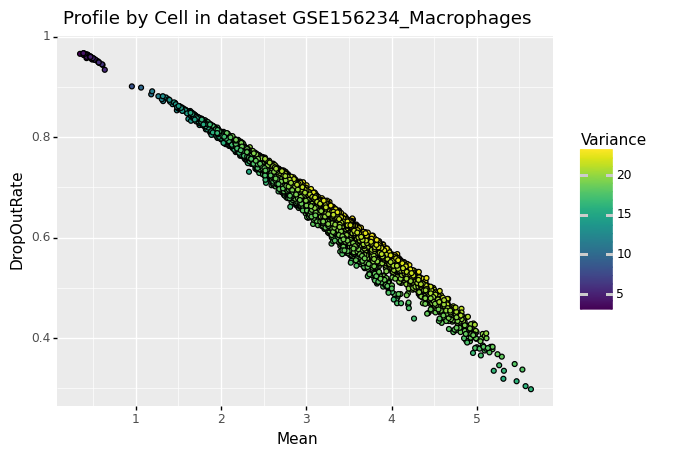

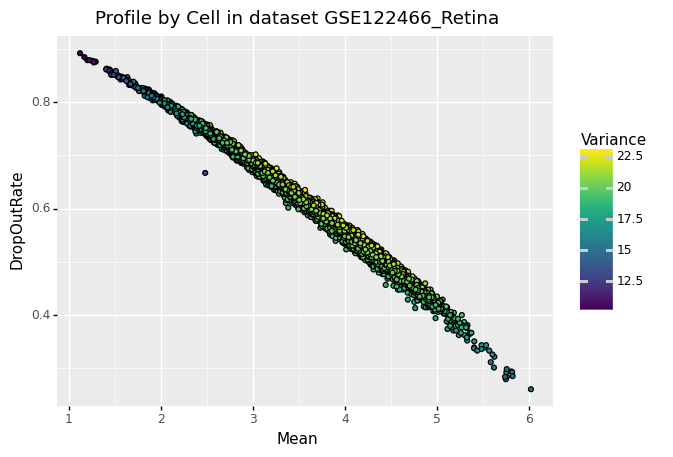

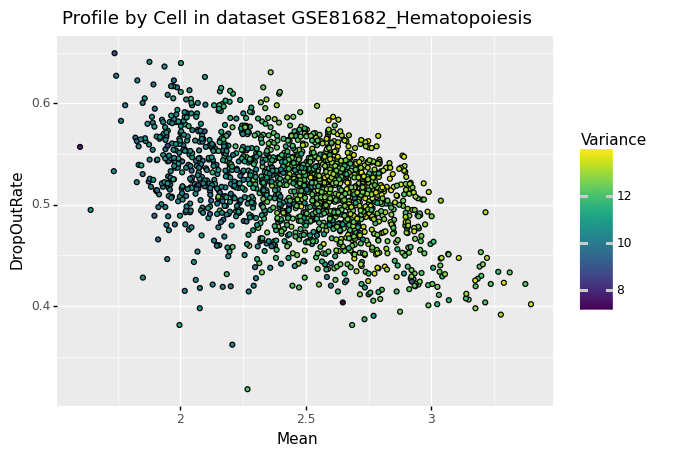

{'GSE156234_Macrophages': <ggplot: (8748280173812)>,
 'GSE122466_Retina': <ggplot: (8748280173809)>,
 'GSE81682_Hematopoiesis': <ggplot: (8748280158970)>}

In [11]:
transposed_original_plots

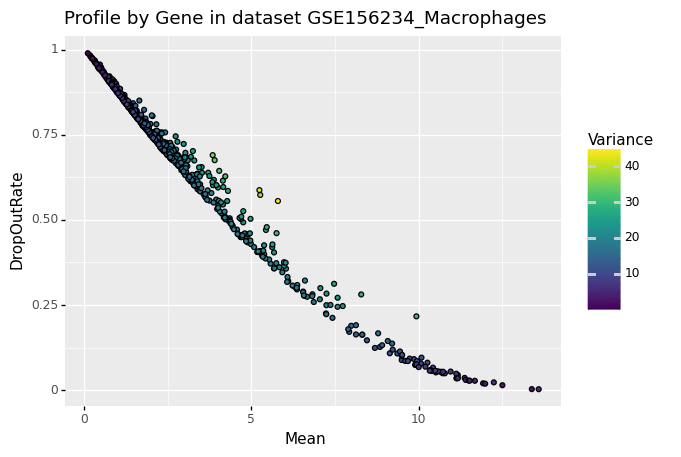

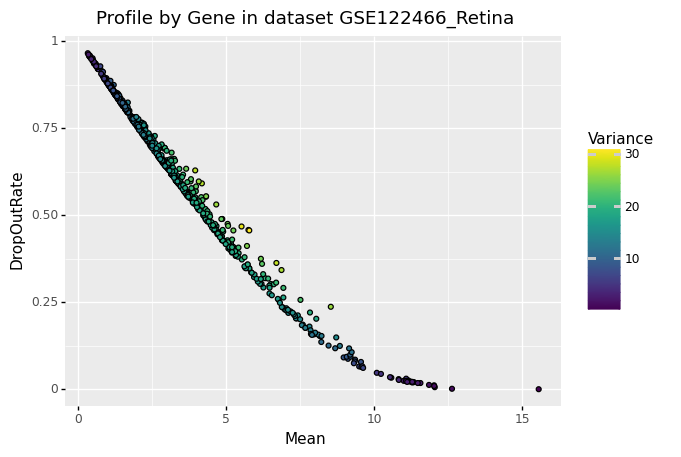

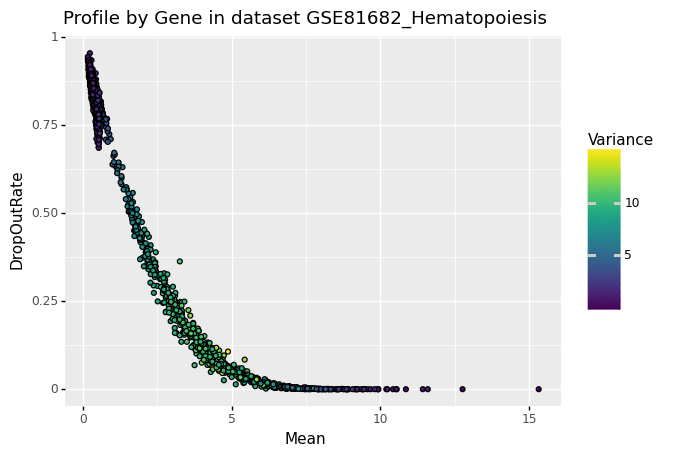

{'GSE156234_Macrophages': <ggplot: (8748280158955)>,
 'GSE122466_Retina': <ggplot: (8748280145917)>,
 'GSE81682_Hematopoiesis': <ggplot: (8748280145914)>}

In [12]:
original_plots

In [13]:
%%time
scbools = {}
for name, frame in frames.items():
    with Timer(f"Training scBoolSeq instance on dataset '{name}'"):
        scbools.update(
            {
                name: scBoolSeq(data=frame, r_seed=RNG_SEED)
                .fit(unimodal_margin_quantile=UMQ, n_threads=THREADS)
                .simulation_fit(unimodal_margin_quantile=UMQ, n_threads=THREADS)
            }
        )

Training scBoolSeq instance on dataset 'GSE156234_Macrophages': 27.77389
Training scBoolSeq instance on dataset 'GSE122466_Retina': 19.32127
Training scBoolSeq instance on dataset 'GSE81682_Hematopoiesis': 20.19534
CPU times: user 22.5 s, sys: 259 ms, total: 22.7 s
Wall time: 1min 7s


In [14]:
%%time
synthetic_frames = {}
for name, _scbool in scbools.items():
    n_samples = _scbool.data.shape[0]
    with Timer(f"Generating {n_samples} samples for dataset '{name}'"):
        synthetic_frames.update(
            {
                name: sample_from_criteria(
                    _scbool.simulation_criteria,
                    n_samples=n_samples,
                    n_threads=THREADS,
                )
            }
        )

Generating 7738 samples for dataset 'GSE156234_Macrophages': 2.03464
Generating 5347 samples for dataset 'GSE122466_Retina': 2.65485
Generating 1656 samples for dataset 'GSE81682_Hematopoiesis': 10.20798
CPU times: user 223 ms, sys: 624 ms, total: 846 ms
Wall time: 14.9 s


In [15]:
synthetic_descriptions = {
    name: resume_dor_criteria(frame) 
    for name, frame in synthetic_frames.items()
}
synthetic_transposed_frames = { 
    source: frame.T 
    for source, frame in synthetic_frames.items() 
}
synthetic_transposed_descriptions = {
    name: resume_dor_criteria(frame) 
    for name, frame in synthetic_transposed_frames.items()
}

In [16]:
synthetic_transposed_plots = {
    name: plot_zero_inflation(frame, name=name, by="Cell")
    for name, frame in synthetic_transposed_descriptions.items()
}
synthetic_plots = {
    name: plot_zero_inflation(frame, name=name, by="Gene")
    for name, frame in synthetic_descriptions.items()
}

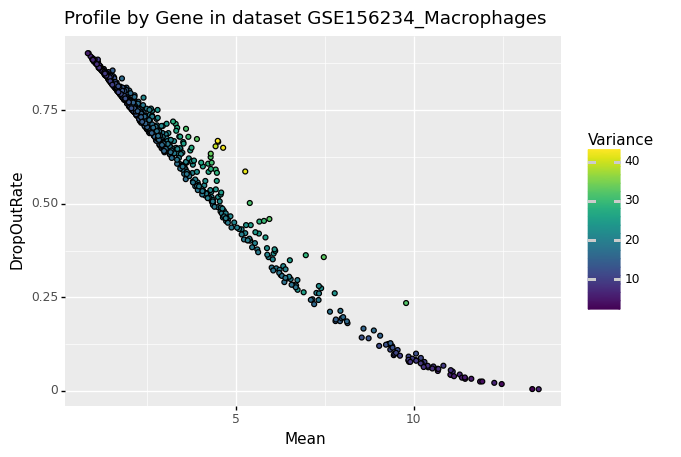

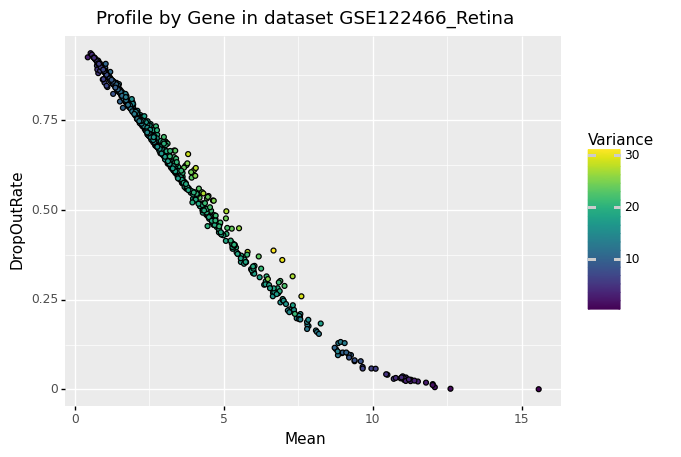

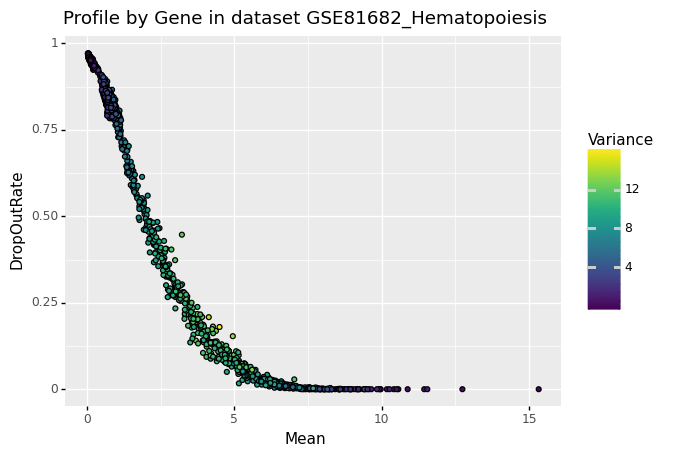

{'GSE156234_Macrophages': <ggplot: (8748159076678)>,
 'GSE122466_Retina': <ggplot: (8748158864457)>,
 'GSE81682_Hematopoiesis': <ggplot: (8748158882301)>}

In [17]:
synthetic_plots

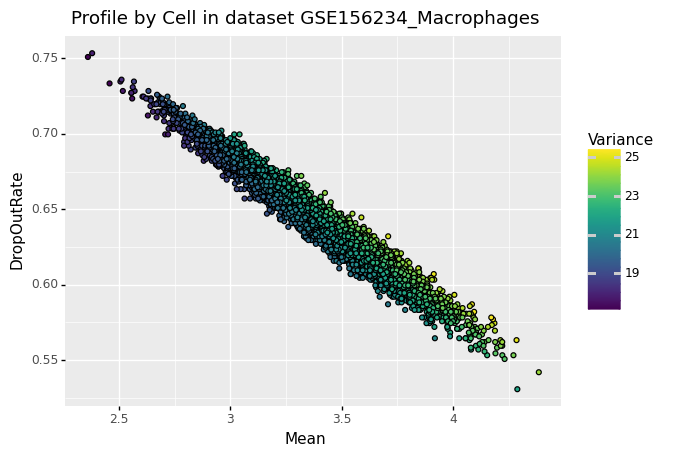

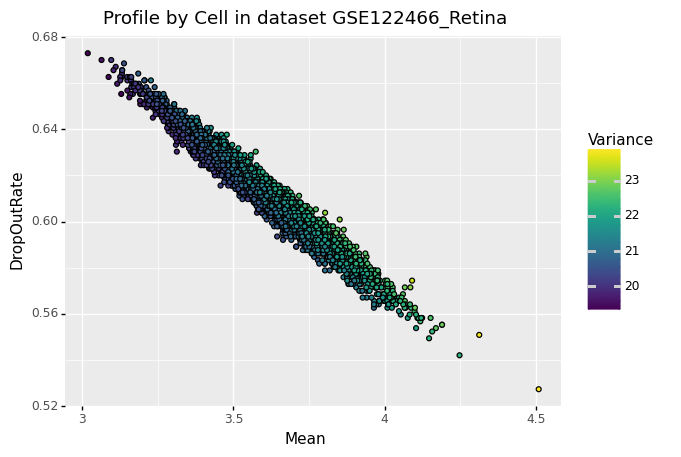

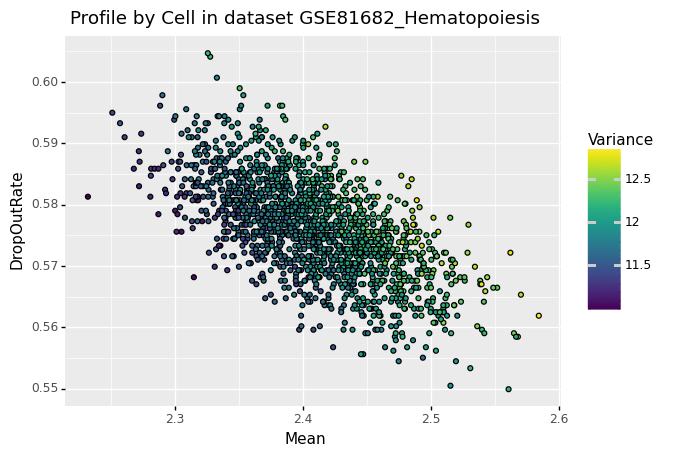

{'GSE156234_Macrophages': <ggplot: (8748158925978)>,
 'GSE122466_Retina': <ggplot: (8748158971055)>,
 'GSE81682_Hematopoiesis': <ggplot: (8748159021972)>}

In [18]:
synthetic_transposed_plots

In [19]:
def plot_zero_inflation(frame, name, by):
    return (
        ggplot(frame)
            + geom_point(aes(x="Mean", y="DropOutRate", fill="Variance"))
            + g.ggtitle(f"Profile by {by} in dataset {name}")
    )

In [20]:
merged_descriptions = {}
for name in descriptions.keys():
    _original = descriptions[name].copy(deep=True)
    _original['Data'] = 'Original' 
    _synthetic = synthetic_descriptions[name].copy(deep=True)
    _synthetic["Data"] = "Synthetic"
    merged_descriptions.update({
        name: pd.concat((_original, _synthetic), axis="rows")
    })
    

In [21]:
merged_descriptions["GSE122466_Retina"]

,Mean,Median,Mean_nz,Median_nz,Variance,DropOutRate,Data
St18,0.577055,0.000000,8.667164,8.454397,4.710608,0.933421,Original
Mybl1,0.914854,0.000000,8.492573,8.337054,7.029363,0.892276,Original
Tfap2d,0.600877,0.000000,8.590607,8.536049,4.866594,0.930054,Original
Tfap2b,1.198526,0.000000,9.536488,9.605495,10.190268,0.874322,Original
Mcm3,2.465106,0.000000,8.631906,8.591019,15.431997,0.714419,Original
...,...,...,...,...,...,...,...
Npm3,2.431041,0.000000,8.563094,8.552392,15.065698,0.716102,Synthetic
Ina,1.914514,0.000000,10.036183,10.043104,15.709874,0.809239,Synthetic
Usmg5,7.566816,9.122228,9.400503,9.367835,14.459638,0.195063,Synthetic
Tcf7l2,0.956467,0.000000,8.787339,8.836732,7.549851,0.891154,Synthetic


In [22]:
merged_description_plots = {}
for name, _summary in merged_descriptions.items():
    merged_description_plots.update({
        name: g.ggplot(_summary, g.aes("Mean", "DropOutRate"))
            + g.theme(text=g.element_text(size=TEXT_SIZE))
            + g.geom_point(g.aes(fill="Variance"))
            + g.facet_wrap("~Data")
            + g.labels.ggtitle(name)
    })

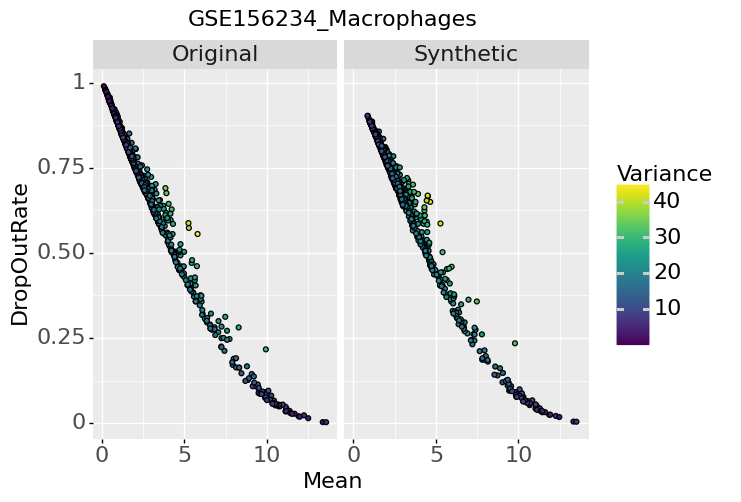

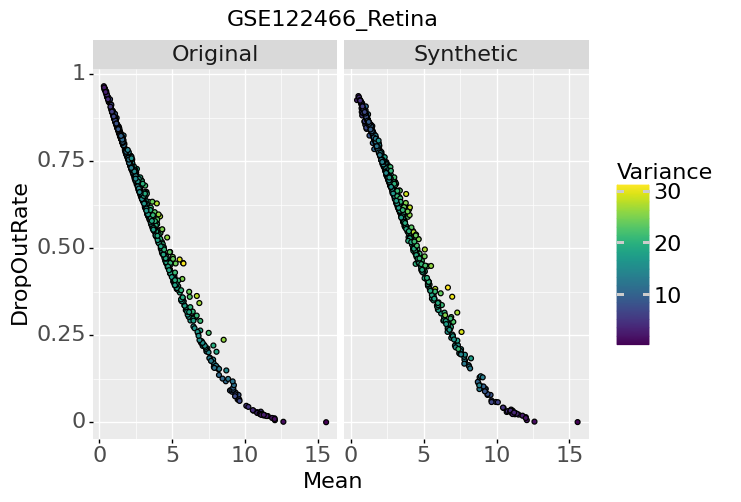

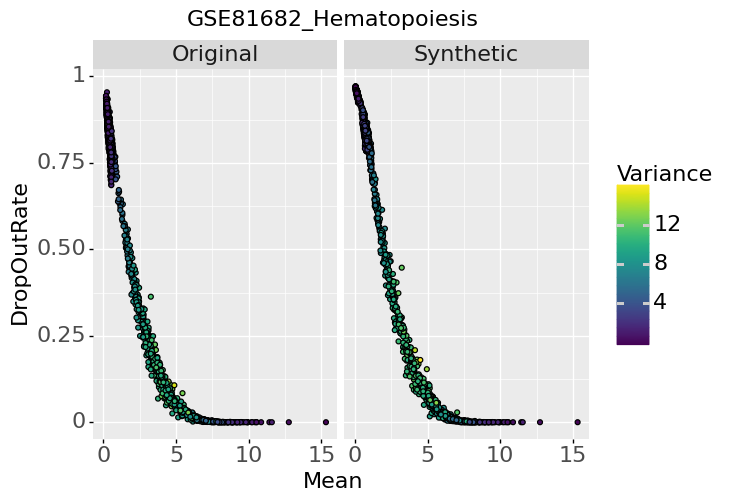

{'GSE156234_Macrophages': <ggplot: (8748279789044)>,
 'GSE122466_Retina': <ggplot: (8748280107192)>,
 'GSE81682_Hematopoiesis': <ggplot: (8748279985704)>}

In [23]:
merged_description_plots

In [24]:
save_plot_dict(merged_description_plots, location=_publish_dir, tag="zero_inflation")